In [ ]:
#Initialize HDFS environment and store dataset to local machine
!hdfs dfs -mkdir hdfs:///bigdata
!gcloud storage cp gs://my-bigdata-project-rn/landing/itineraries.csv .
!hdfs dfs -put itineraries.csv hdfs:///bigdata
!hdfs dfs -ls hdfs:///bigdata

Copying gs://my-bigdata-project-rn/landing/itineraries.csv to file://itineraries.csv
  Completed files 1/1 | 29.0GiB/29.0GiB | 181.4MiB/s                           

Average throughput: 182.6MiB/s


In [1]:
#Importing dataframe library
import pandas as pd

import numpy as np

#Import SparkSession
from pyspark.sql import SparkSession
import pyspark

#Importing graphical libraries
import matplotlib.pyplot as plt

import seaborn as sns

# EDA

In [2]:
#Initialize Spark Session
spark = SparkSession.builder.appName('SparkDemo').master('local[*]').config('spark.driver.memory', '15g').getOrCreate()
spark

In [3]:
#Define file path.
landing_data_path = "D:\Baruch\CIS4130\landing_itineraries.csv"
#Read file using Spark and infer the schema
df = spark.read.csv(landing_data_path, header=True, inferSchema=True)
#List all the columns and their data types
df.printSchema()
#Schema correctly defined all columns, no manual adjustments necessary

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCod

In [4]:
#Count the number of records
df.count()

82138753

In [5]:
#Finding the count of total null fields
import pyspark.sql.functions as F

def nullCheck(sdf):
    #Transform all columns to string. Necessary to iterate through all values
    sdf = sdf.select([F.col(c).cast("string") for c in sdf.columns])

    #Credit: https://stackoverflow.com/a/44631639
    #For loop to select each column and count a value when a null is seen.
    sdf.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()

    #Re-read csv file to get correct schema back:
    sdf = spark.read.csv(landing_data_path, header=True, inferSchema=True)
    
nullCheck(df)

+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---

In [6]:
#Re-print schema to ensure it is correct
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCod

In [7]:
#Check for duplicate rows
#Credit: https://www.statology.org/pyspark-find-duplicates/
df.exceptAll(df.dropDuplicates()).show()

+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---

In [8]:
#Finding min, max, avg, and stdev of numeric columns

df.select("elapsedDays", "baseFare", "totalFare", "seatsRemaining", "totalTravelDistance").summary("min", "max", "mean", "stddev").show()

+-------+-------------------+-----------------+------------------+-----------------+-------------------+
|summary|        elapsedDays|         baseFare|         totalFare|   seatsRemaining|totalTravelDistance|
+-------+-------------------+-----------------+------------------+-----------------+-------------------+
|    min|                  0|             0.01|             19.59|                0|                 89|
|    max|                  2|          7662.33|           8260.61|               10|               7252|
|   mean|0.14965308762357277|292.6628527106182|340.38684913979074|5.976311522528228| 1609.9033457519408|
| stddev| 0.3567567481729478|183.1887833739835|196.02950991170573|2.880567111463761|  857.3257345475686|
+-------+-------------------+-----------------+------------------+-----------------+-------------------+



In [9]:
#Finding max and min dates

#Min dates
df.agg({'searchDate': 'min',
       'flightDate': 'min'}).show()

#Max dates
df.agg({'searchDate': 'max',
       'flightDate': 'max'}).show()

+---------------+---------------+
|min(flightDate)|min(searchDate)|
+---------------+---------------+
|     2022-04-17|     2022-04-16|
+---------------+---------------+

+---------------+---------------+
|max(flightDate)|max(searchDate)|
+---------------+---------------+
|     2022-11-19|     2022-10-05|
+---------------+---------------+



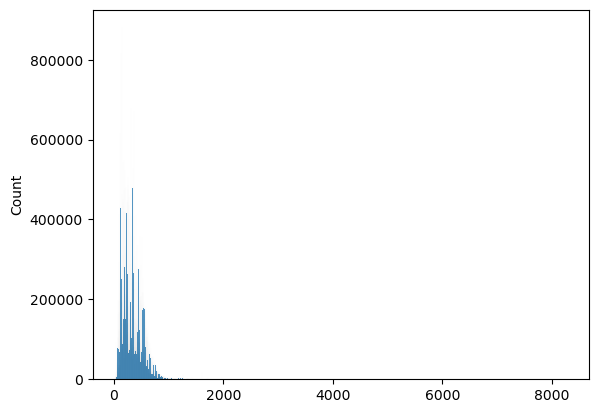

In [10]:
#Storing all the figures in a list
figure_list = []

#Create list to store all values of totalFare
#Credit: https://stackoverflow.com/a/63120999
totalFare_list = list(df.select('totalFare').toPandas()['totalFare'])

#Histogram of how many tickets are at a specific price
figure_list.append(sns.histplot(totalFare_list).get_figure())
plt.show()

In [11]:
totalFare_list = None

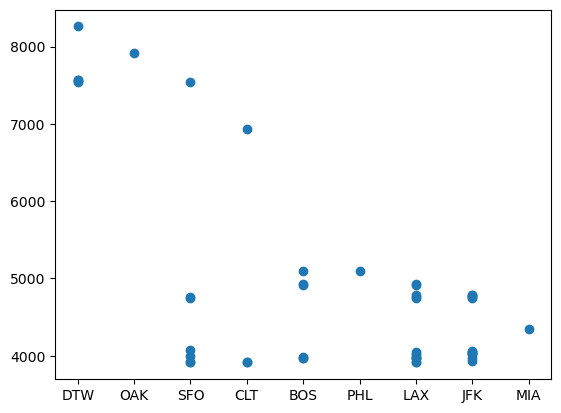

In [12]:
#Plotting the 50 most expensive ticket prices
#Store 50 highest prices alongside its designated airport in a variable. Convert to Pandas to graph it.
top_50_price = df.select('totalFare', 'destinationAirport').distinct().orderBy(F.desc('totalFare')).limit(50).toPandas()

#Scatter plot showing the highest prices and its destination airport.
figure_list.append(plt.scatter(top_50_price['destinationAirport'], top_50_price['totalFare']).get_figure())
plt.show()

In [13]:
top_10_dest_airports = df.groupBy('destinationAirport').count().orderBy(F.desc('count')).limit(10).toPandas()

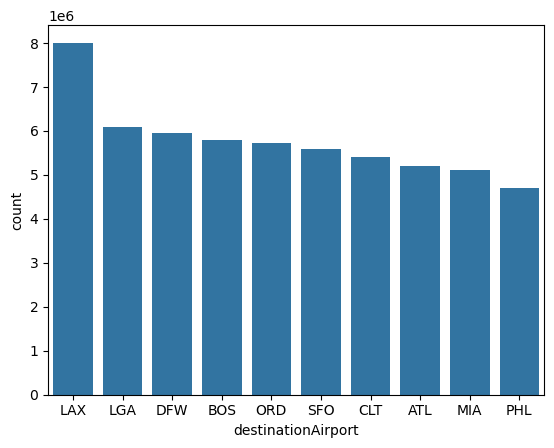

In [14]:
#Finding the 10 most popular destination airports
figure_list.append(sns.barplot(top_10_dest_airports, x='destinationAirport', y='count').get_figure())
plt.show()

In [15]:
top_15_price = None
top_10_dest_airports = None
top_10_df = None

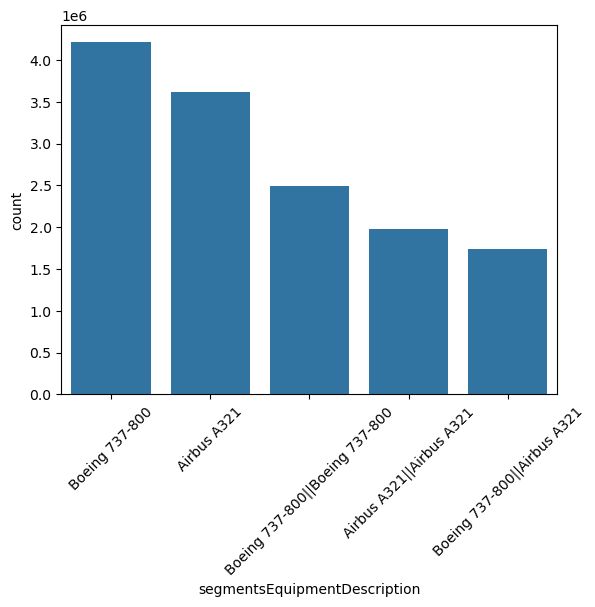

In [16]:
#Finding the 5 most used airplane models
top_5_planes = df.groupBy('segmentsEquipmentDescription').count().orderBy(F.desc('count')).limit(5).toPandas()
plt.xticks(rotation=45)
figure_list.append(sns.barplot(top_5_planes, x='segmentsEquipmentDescription', y='count').get_figure())
plt.show()

In [17]:
top_5_planes = None
top_5_df = None

In [18]:
top_5_airlines = df.groupBy('segmentsAirlineName').count().orderBy(F.desc('count')).limit(5).toPandas()

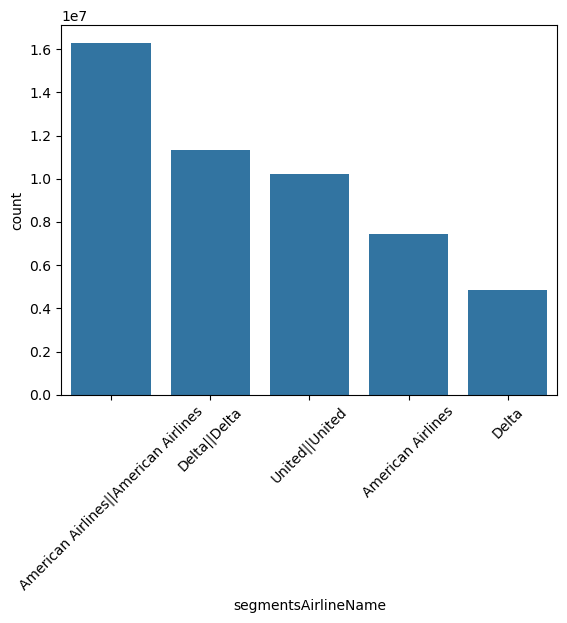

In [19]:
#Finding the 5 most popular airlines on 1st flight
plt.xticks(rotation=45)
figure_list.append(sns.barplot(top_5_airlines, x='segmentsAirlineName', y='count').get_figure())
plt.show()

In [20]:
top_5_airlines = None
top_5_df = None

In [21]:
#Store all numeric columns in a new pandas dataframe
numeric_columns = ['elapsedDays', 'baseFare', 'totalFare','seatsRemaining', 'totalTravelDistance']
numeric_df = df.select(numeric_columns).toPandas()

#Ensure the columns are numeric
numeric_df.dtypes

elapsedDays              int32
baseFare               float64
totalFare              float64
seatsRemaining           int32
totalTravelDistance    float64
dtype: object

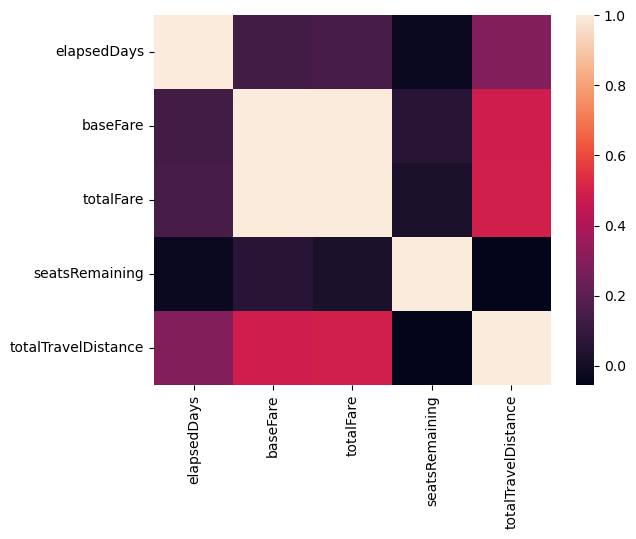

In [22]:
#Heatmap showing correlation between numeric columns
figure_list.append(sns.heatmap(numeric_df[numeric_columns].corr()).get_figure())
plt.show()

In [23]:
numeric_columns = None
numeric_df = None

In [26]:
!mkdir ./Graphs

The syntax of the command is incorrect.


In [27]:
#Saving the graph images
for fig in figure_list:
    #Credit: https://stackoverflow.com/questions/55942693/how-do-i-save-the-entire-graph-without-it-being-cut-off
    fig.figure.savefig(f'./Graphs/Graph{figure_list.index(fig)+1}.png', dpi=1000, bbox_inches='tight')

# Data Cleaning

In [ ]:
#Removing unnecessary columns

#Base fair is removed as the total fair is a more important and concise indicator of price
#isRefundable are false for nearly the entire dataset. Shows no use like this.
#Other non-segment columns are removed for being index-like or being seen as a duplicate column.
#Listed segment columns are summarized in travel duration. Airline name is not needed since we have codes for it.
#Unix time is kept for now to determine if it will be used in Machine learning
df = df.drop('legId', 'fareBasisCode', 'isRefundable', 'baseFare', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw', 'segmentsDepartureTimeEpochSeconds', 'segmentsArrivalTimeEpochSeconds', 'segmentsAirlineName')

df = df.dropna()
#Ensure there are no more nulls
nullCheck(df)

In [ ]:
#Delete rows where totalFare is greater than 6000:
df = df.filter('totalFare < 6000')

In [6]:
print('Number of rows:',df.count())
print('Number of columns',len(df.columns))

Number of rows: 74754290
Number of columns 18


In [ ]:
df.write.parquet('gs://my-bigdata-project-rn/cleaned/cleaned_itineraries.parquet', mode='overwrite')

Py4JJavaError: An error occurred while calling o71.parquet.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:736)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:271)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:287)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:865)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:547)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:587)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:586)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:559)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:705)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:354)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:178)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:173)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:874)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:548)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:569)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:592)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:689)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:78)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1814)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1791)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:302)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:181)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:50)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:48)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:153)
	at org.apache.spark.util.ShutdownHookManager$.<init>(ShutdownHookManager.scala:58)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:326)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:343)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:894)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:180)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:203)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:90)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1039)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1048)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:468)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:439)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:516)
	... 21 more


In [12]:
!gcloud storage cp cleaned_itineraries.parquet gs://my-bigdata-project-rn/cleaned/cleaned_itineraries.parquet

uploading large objects. If you would like to opt-out and instead
perform a normal upload, run:
`gcloud config set storage/parallel_composite_upload_enabled False`
If you would like to disable this warning, run:
`gcloud config set storage/parallel_composite_upload_enabled True`
Note that with parallel composite uploads, your object might be
uploaded as a composite object
(https://cloud.google.com/storage/docs/composite-objects), which means
that any user who downloads your object will need to use crc32c
checksums to verify data integrity. gcloud storage is capable of
computing crc32c checksums, but this might pose a problem for other
clients.

Copying file://cleaned_itineraries.parquet to gs://my-bigdata-project-rn/cleaned/cleaned_itineraries.parquet
  Completed files 32/1 | 1.5GiB/1.5GiB | 414.5MiB/s                            

Average throughput: 427.5MiB/s
